# Brexit under the lens

<p align="center">
  <img width="460" height="300" src="https://www.dachser.com/en/mediaroom/images/Corporate/Marktinformation/shutterstock_417868516_rdax_65.jpg">
</p>

## Import library

In [1]:
# Here we load the data folder in the sharedrives
# The data folder is in the 'drive/Shareddrives/Ada'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downgrade the pandas version so that we can read data in chunksize

In [ ]:
pip install pandas==1.0.5


## Pipline and preprocessing

In [ ]:
# The original datafile path, contains all the Quote from 2015-2020
dataset_path='/content/drive/Shareddrives/Ada/Quotebank'

# The path store the first preprocessed Pickles 
pickle_path='/content/drive/Shareddrives/Ada/pickle'

# Specify which cols to drop and which to keep
use_cols=["qids","quoteID","quotation","speaker","date","numOccurrences","probas","urls","phase"]
ignore_cols=[]

# The chunk_size for the pickles
chunk_size = 600000 

In [ ]:
# here if you want to remove the pickles and try to make new pickles
# shutil.rmtree(pickle_path)
# os.mkdir(pickle_path)

In [ ]:
# Here check if we already process data and save them into pickles
# If not process them into pickles
if not os.listdir(pickle_path):
   for name in glob.glob(dataset_path + "/*.bz2"):
     print("pickling "+name)
     pickle_name=name.split('/')[6].split('.')[0]
     reader = pd.read_json(name, chunksize=chunk_size, lines=True, compression='bz2')   
     for i, chunk in enumerate(reader):
       chunk=chunk[use_cols]
       out_file = pickle_path + "/"+ pickle_name + "_{}.pkl".format(i+1)
       with open(out_file, "wb") as f:
           pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)
       chunk=""    
   print('Pickles made!,ready to go!')       
else:    
   print("Already processed data into pickles, you can use them right away!")

Already processed data into pickles, you can use them right away!


In [ ]:

# Here is an example how to filter the pickles and try to get useful informations
# Where we store the processed pickle
processed_path='/content/drive/Shareddrives/Ada/processed' 
out_file = processed_path + "/"+"Brexit_related_quote.pkl"


if not os.path.exists(out_file):
  # Specify the orginal pickles we want to process
  # which are in the pickle folder
  data_p_files=[]
  for name in glob.glob(pickle_path + "/*.pkl"):
   data_p_files.append(name)

  # Here is the key words we want to filter in the quotations
  searchfor = ['Brexit','European Union','Theresa May', 'David Cameroun', 'Boris Johnson', 'backstop',
              'Prime minister', 'no deal', 'UK', 'EU', 'transition period']
  
  # Add all the df into here and store it into pickle in the end
  appended_data=[]
  for i in range(len(data_p_files)):
    print("processing"+data_p_files[i])
    df=pd.read_pickle(data_p_files[i])
    # Filter quotations only in phase E
    df=df.loc[df['phase']=='E']
    df=df.loc[df['speaker']!='None']
    # Filter quotations only relevant to Brexit or both UK and EU firtsly
    df=df.loc[df['quotation'].str.contains('Brexit|UK.*EU|EU.*UK|United Kingdom.*European Union|European Union.*United Kingdom|British.*EU|EU.*British',case = False)]
    # Define key words relevant to Brexit to filter related news from the quotations that only relevant to UK and EU 
    searchfor = ['brexit','leave campaign and remain campaign','no deal', 'transition period','leave','withdral','referendum', 'split from']
    # Filter news relevant to some keywords
    df=df.loc[df['quotation'].str.contains('|'.join(searchfor),case = False)]

    appended_data.append(df)
    # release the df at the end of process
    # To free the memory
    df = ""  
  
  # concat and append
  appended_data = pd.concat(appended_data)
  appended_data.to_pickle(out_file)
else:    
   print("Already processed data into pickle, you can use them right away!")

Already processed data into pickle, you can use them right away!


In [ ]:
#Here we add the attribute 

all_pickle_path='/content/drive/Shareddrives/Ada/processed/All_attribute.pkl'
if not os.path.exists(all_attribute_pickle_path):
  parquet_path='/content/drive/Shareddrives/Ada/Project datasets/speaker_attributes.parquet'
  label_path='/content/drive/Shareddrives/Ada/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
  df=pd.read_pickle('/content/drive/Shareddrives/Ada/processed/Brexit_related_quote.pkl')
  df=df.loc[df['speaker']!='None']
  df['qids']=df['qids'].map(lambda x:str(x[0]))
  df.rename(columns={"qids":"id"},inplace=True)
  parquet_cols=['id','label','date_of_birth','nationality','gender','ethnic_group','occupation','party','academic_degree','religion']

  for name in glob.glob(parquet_path + "/*.parquet"):
    par=pd.read_parquet(name)
    par=par[parquet_cols]
    #see if we already merge
    if 'gender' not in df.columns:
      df = pd.merge(df, par,on='id',how='left')
    else:
      df=df.set_index('id')
      df.update(par.set_index('id'))
      df.reset_index(inplace=True)

  df = df.fillna('0')
  cols=['nationality','gender','ethnic_group','occupation','party','academic_degree','religion']

  for col in cols:
    df[col]=df[col].map(lambda x: x[0])

  df_label=pd.read_csv(label_path,compression='bz2',index_col='QID')
  for col in cols:
    df[col]=df[col].map(lambda x: df_label.loc[x]['Label'] if x in df_label.index else x)
  df.to_pickle(all_attribute_pickle_path)

In [9]:
df=pd.read_pickle('/content/drive/Shareddrives/Ada/processed/All_attribute.pkl')
df.head(5)

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion
0,Q13560788,2019-04-24-017613,I am excited to continue my amazing journey at...,Sylvia Rhone,"[[Sylvia Rhone, 0.7704], [Rob Stringer, 0.1751...",2019-04-24 13:05:42,1,[https://completemusicupdate.com/article/sylvi...,E,Sylvia Rhone,[+1952-03-11T00:00:00Z],United States of America,female,African Americans,businessperson,0,0,0
1,Q6162006,2019-05-17-030006,I am experiencing first-hand what a lot of the...,Jason Behrendorff,"[[Jason Behrendorff, 0.9153], [None, 0.0847]]",2019-05-17 02:02:52,2,[http://www.brisbanetimes.com.au/sport/cricket...,E,Jason Behrendorff,[+1990-04-20T00:00:00Z],Australia,male,0,cricketer,0,0,0
2,Q2014922,2019-03-22-028138,I am from India. I use that once in a while.,Andy Cohen,"[[Andy Cohen, 0.5437], [None, 0.3675], [Priyan...",2019-03-22 06:43:13,2,[https://www.bollywoodhungama.com/news/bollywo...,E,Andy Cohen,[+1968-06-02T00:00:00Z],United States of America,male,0,television presenter,0,0,0
3,Q19661204,2019-09-29-009937,I am from Kolkata which is known for Durga Puj...,Ishita Ganguly,"[[Ishita Ganguly, 0.5078], [None, 0.4922]]",2019-09-29 09:51:01,2,[https://www.prokerala.com/news/articles/a9652...,E,Ishita Ganguly,0,India,female,0,actor,0,0,0
4,Q1897911,2019-03-22-028139,"I am from the ghettos of America, and he is on...",Meek Mill,"[[Meek Mill, 0.7858], [None, 0.1339], [Myra Kr...",2019-03-22 18:30:42,1,[http://www.nytimes.com/2019/03/22/style/rober...,E,Meek Mill,[+1987-05-06T00:00:00Z],United States of America,male,African Americans,rapper,0,0,0


In [11]:
# Word cloud

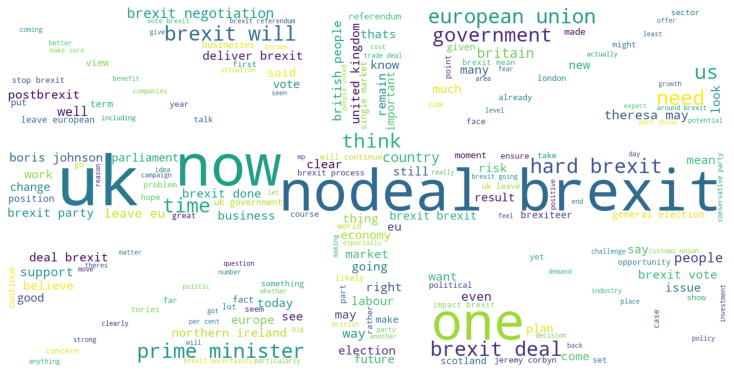

In [ ]:
#Create word cloud using the latest pickle 'processed/Brexit_related_quote.pkl'
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import string
quotation_words = ''
stopwords = set(STOPWORDS) 
qute_txt='/content/drive/Shareddrives/Ada/processed/qutos.txt'

if not os.path.exists(qute_txt):
  with open(qute_txt,"w+") as f:
    # iterate through the csv file 
    for val in df.quotation: 
      # typecaste each val to string 
      val = str(val)
      for c in string.punctuation:
        val = val.replace(c,'') 
      # split the value 
      tokens = val.split() 
      #Converts each token into lowercase 
      for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
      for words in tokens: 
        f.write(str(words)+ '\n')
  f.close()

  quotation_words=open (qute_txt).read()
  mask = np.array(Image.open('/content/drive/Shareddrives/Ada/img/Flag_of_the_United_Kingdom.png'))
  wordcloud = WordCloud(width = 800, height = 800, 
              background_color ='white', 
              mask=mask,
              stopwords = stopwords, 
              min_font_size = 10).generate(quotation_words) 

  # plot the WordCloud image                        
  plt.figure(figsize = (10, 20), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.show() 
  ## stop words 

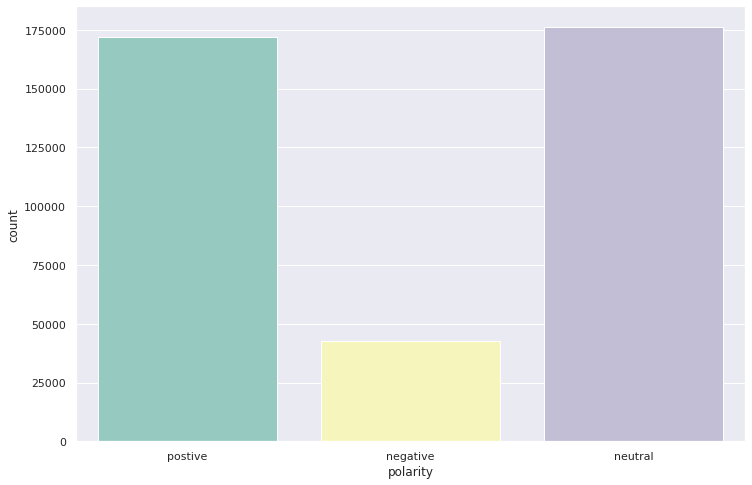

In [10]:
# sentimental analysis
from textblob import TextBlob
if 'polarity' not in df.columns:
  df.insert(df.shape[1],'polarity','None')
def polarity_to_text(blob):
      if (blob.sentiment.polarity > 0.1):
        #'Polarity is positive 😊'
          return 'postive'
      elif(blob.sentiment.polarity <= 0.1 and  blob.sentiment.polarity >= -0.1):
          # 'Polarity is neutral 😐'
          return 'neutral'
      else:
        # 'Polarity is negative 😡' 
          return 'negative'


if df.iloc[1].polarity=="None":
  for i,data in df.iterrows():
    blob = TextBlob(data.quotation)
    emotion=polarity_to_text(blob)
    df.at[i,'polarity']=emotion

plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="polarity", data=df,palette="Set3")
plt.show()

In [12]:
# Remove punctuation
df['quotation_processed'] = \
df["quotation"].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['quotation_processed'] = \
df['quotation_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df['quotation_processed'].head()

0    i am excited to continue my amazing journey at...
1    i am experiencing first-hand what a lot of the...
2           i am from india i use that once in a while
3    i am from kolkata which is known for durga puj...
4    i am from the ghettos of america and he is one...
Name: quotation_processed, dtype: object

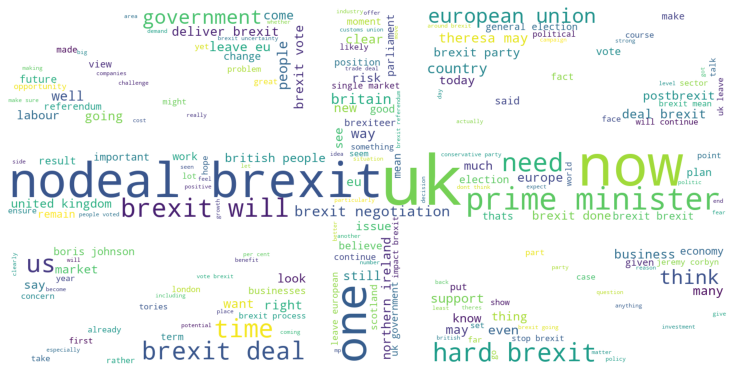

In [21]:
# compare with the old word cloud to see if the processing did smt
# dont think it will add much since the processing is already done
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import string
quotation_words = ''
stopwords = set(STOPWORDS) 
qute_txt='/content/drive/Shareddrives/Ada/processed/qutos_trial_lda.txt'

if not os.path.exists(qute_txt):
  with open(qute_txt,"w+") as f:
    # iterate through the csv file 
    for val in df.quotation_processed: 
      # typecaste each val to string 
      val = str(val)
      for c in string.punctuation:
        val = val.replace(c,'') 
      # split the value 
      tokens = val.split() 
      #Converts each token into lowercase 
      for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
      for words in tokens: 
        f.write(str(words)+ '\n')
  f.close()

quotation_words=open (qute_txt).read()
mask = np.array(Image.open('/content/drive/Shareddrives/Ada/img/Flag_of_the_United_Kingdom.png'))
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            mask=mask,
            stopwords = stopwords, 
            min_font_size = 10).generate(quotation_words) 

# plot the WordCloud image                        
plt.figure(figsize = (10, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 
## stop words

In [22]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['thats', 'one', 'let', 'put', 'lot','mean'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.quotation_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['excited', 'continue', 'amazing', 'journey', 'epic', 'records', 'supported', 'rob', 'stringer', 'vision', 'leadership', 'everything', 'testament', 'incredible', 'artists', 'set', 'bar', 'entire', 'epic', 'culture', 'inspiring', 'dedicated', 'executive', 'team', 'every', 'day', 'enriching', 'legacy', 'great', 'label']


In [23]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]


## LDA model training

In [24]:
from pprint import pprint
# number of topics
num_topics = 15
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"years" + 0.018*"two" + 0.015*"last" + 0.014*"three" + 0.012*"months" '
  '+ 0.011*"five" + 0.011*"ago" + 0.009*"year" + 0.009*"old" + 0.009*"people"'),
 (1,
  '0.039*"new" + 0.016*"na" + 0.010*"gon" + 0.009*"experience" + 0.006*"brand" '
  '+ 0.006*"platform" + 0.006*"excited" + 0.006*"street" + 0.006*"unique" + '
  '0.006*"park"'),
 (2,
  '0.014*"community" + 0.011*"work" + 0.010*"support" + 0.008*"public" + '
  '0.008*"health" + 0.008*"help" + 0.007*"need" + 0.007*"care" + 0.007*"also" '
  '+ 0.006*"people"'),
 (3,
  '0.014*"deal" + 0.013*"india" + 0.012*"minister" + 0.011*"country" + '
  '0.008*"would" + 0.007*"vote" + 0.007*"prime" + 0.007*"question" + '
  '0.006*"read" + 0.006*"made"'),
 (4,
  '0.011*"power" + 0.006*"sense" + 0.006*"green" + 0.006*"using" + '
  '0.006*"questions" + 0.006*"housing" + 0.005*"powerful" + '
  '0.005*"constitution" + 0.005*"sad" + 0.005*"common"'),
 (5,
  '0.014*"case" + 0.012*"court" + 0.009*"election" + 0.008*"justice" + '
  '0.007*"pr

Using N-gram to find subject

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!


In [ ]:
lda_model

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

- 2015 ( era before brexit)
- 23/6/2016: uk votes to leave
- 13/7/2016: change of prime minister Cameroun to may
- 23/6/2017: trigger warning, 2 years countdown
- 8/12/2017 to 25/11/2018: backstop
- 24/6/2019 : may resigns
- 24/7/2019: boris is pm
- 2/10/2019: brexit deal 
- 12/12/2019: election day
- 31/01/2020- 16/10/2020: departed, discusion the deal/ no deal exit

# New Section

**Mahdi is working in here :)**

In [ ]:
df.head()

,qids,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase
232,[Q20251661],2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E
2828,[Q694676],2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E
3153,"[Q1341937, Q16211383, Q694825]",2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E
3776,[Q6837191],2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E
4886,[Q1728820],2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E


**Adding the name of the domain (taking it from the url)**

In [ ]:
#Testing
from urllib.parse import urlparse
list_domains = []
for url in df.iloc[3776].urls:
  list_domains.append(urlparse(url).netloc)

list_domains

['www.mirror.co.uk', 'www.liverpoolecho.co.uk']

In [ ]:
#Function tp change urls to domains
def function(row):
  list_domains = []
  for url in row:
    list_domains.append(urlparse(url).netloc)
  return list_domains

df['domains'] = df['urls'].apply(function)
df

,qids,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,domains
232,[Q20251661],2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,[voanews.com]
2828,[Q694676],2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,[www.expressandstar.com]
3153,"[Q1341937, Q16211383, Q694825]",2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,[www.yorkshirepost.co.uk]
3776,[Q6837191],2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,[www.belfasttelegraph.co.uk]
4886,[Q1728820],2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,[blogs.independent.co.uk]
...,...,...,...,...,...,...,...,...,...,...
20699374,[Q567],2015-10-07-001521,a Brexit now [ look ] more likely,Angela Merkel,"[[Angela Merkel, 0.5723], [Francois Hollande, ...",2015-10-07 07:54:43,1,[http://breitbart.com/london/2015/10/07/farage...,E,[breitbart.com]
20708455,[Q1395663],2015-03-10-096295,We saw strong growth in the UK last year but I...,Sir Martin Sorrell,"[[Sir Martin Sorrell, 0.8715], [None, 0.1285]]",2015-03-10 00:51:18,1,[http://independent.co.uk/news/business/news/w...,E,[independent.co.uk]
20728876,[Q23769958],2015-10-09-130507,We look forward to supporting their push to pe...,Richard Tice,"[[Richard Tice, 0.9685], [None, 0.0262], [Davi...",2015-10-09 07:29:35,5,[http://feeds.theguardian.com/c/34708/f/663865...,E,"[feeds.theguardian.com, feeds.theguardian.com,..."
20775049,[Q503143],2015-08-24-049253,"It would be a travesty to both, for Europe and...",Alexander Stubb,"[[Alexander Stubb, 0.9019], [None, 0.0783], [G...",2015-08-24 11:37:42,7,[http://af.reuters.com/article/worldNews/idAFK...,E,"[af.reuters.com, uk.news.yahoo.com, www.channe..."


In [ ]:
#Let's get the list of all domains and analyse them
list_domains = df['domains'].to_list()
flat_list_of_domains = [item for sublist in list_domains for item in sublist]

In [ ]:
set_unique_domains = set(flat_list_of_domains)

In [ ]:
len(set_unique_domains)

6382

In [ ]:
flat_list_of_domains.count('independent.co.uk')

263

In [ ]:
list_domains_occurences = []
for domain in set_unique_domains:
  list_domains_occurences.append([domain, flat_list_of_domains.count(domain)])

In [ ]:
len(list_domains_occurences)

6382

In [ ]:
sorted_list_domains_occurences = sorted(list_domains_occurences, key=lambda x: x[1], reverse=True)

In [ ]:
sorted_list_domains_occurences[0:5]

[['www.belfasttelegraph.co.uk', 6419],
 ['www.msn.com', 5989],
 ['express.co.uk', 5748],
 ['heraldscotland.com', 4728],
 ['www.wandsworthguardian.co.uk', 4601]]

In [ ]:
df_domains = pd.DataFrame.from_records(sorted_list_domains_occurences)

In [ ]:
df_domains.head(10)

,0,1
0,www.belfasttelegraph.co.uk,6419
1,www.msn.com,5989
2,express.co.uk,5748
3,heraldscotland.com,4728
4,www.wandsworthguardian.co.uk,4601
5,www.thetelegraphandargus.co.uk,4449
6,www.ealingtimes.co.uk,4308
7,www.croydonguardian.co.uk,4230
8,www.middevonstar.co.uk,4227
9,www.thenorthernecho.co.uk,4178


In [ ]:
df_domains.set_axis(['domain', 'frequency'], axis=1, inplace=True)

**Let's add percentages**

In [ ]:
df_domains['percentages'] = df_domains['frequency'].apply(lambda x: x / df.shape[0])

In [ ]:
df_domains

,domain,frequency,percentages
0,www.belfasttelegraph.co.uk,6419,0.063007
1,www.msn.com,5989,0.058786
2,express.co.uk,5748,0.056420
3,heraldscotland.com,4728,0.046408
4,www.wandsworthguardian.co.uk,4601,0.045162
...,...,...,...
6377,www.webmd.boots.com,1,0.000010
6378,www.wallstreetdaily.com,1,0.000010
6379,redresurgence.wordpress.com,1,0.000010
6380,www.crowdfundinsider.com,1,0.000010


**Most invested domains**

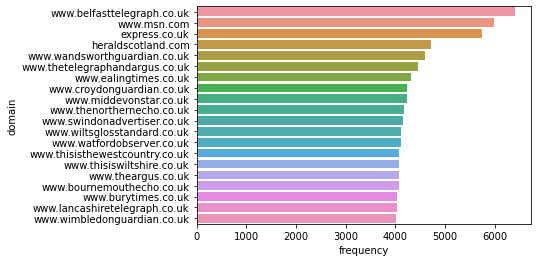

In [ ]:
import matplotlib.pyplot as plt
ax = sns.barplot(x="frequency", y="domain", data=df_domains.head(20))

**Let's now check the country of these domains**

In [ ]:
#Let's add the csv file of all domains with the corresponding countries
df_domain_country = pd.read_csv('/content/drive/Shareddrives/Ada/top-level-domain-names/country-codes-tlds.csv')

In [ ]:
df_domain_country.rename(columns={' tld': 'tld'}, inplace=True)

In [ ]:
df_domain_country['tld'] = df_domain_country['tld'].str.strip()


In [ ]:
df_domain_country.head()

,country,tld
0,Afghanistan,.af
1,Åland,.ax
2,Albania,.al
3,Algeria,.dz
4,American Samoa,.as


In [ ]:
df_domain_country[df_domain_country['tld']=='.af']

,country,tld
0,Afghanistan,.af


DEPENDENT OR OR NOT, COUNTRY

**Add the country of the domain name**

In [ ]:
for index, row in df_domains.iterrows():
  row['domain country'] = df_domain_country.loc[df_domain_country['B'] == row['domain country'], 'A'].iloc[0]